In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_google_vertexai import ChatVertexAI
MODEL_ID="gemini-1.5-flash-001"
PROJECT_ID="genai-exchange-hackathon"
REGION="asia-south1"

llm2 = ChatVertexAI(model_name=MODEL_ID)

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-70b-versatile")

In [4]:
import os
import vertexai
from langchain_google_vertexai import VertexAIEmbeddings
vertexai.init(
        project=os.environ.get("VERTEX_PROJECT_ID"),
        location=os.environ.get("VERTEX_PROJECT_LOCATION")
        )
embeddings = VertexAIEmbeddings(model_name="text-embedding-004", location=REGION, project=PROJECT_ID)

In [5]:
import os
from langchain_qdrant import QdrantVectorStore

def get_vector_retriever():
    QDRANT_URL=os.environ.get("QDRANT_URL")
    QDRANT_API_KEY=os.environ.get("QDRANT_API_KEY")
    vectorstore = QdrantVectorStore.from_existing_collection(
        collection_name="dsa_notes",
        embedding=embeddings,
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    return vectorstore.as_retriever(k=2)

retriever = get_vector_retriever()

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [7]:
from langchain_community.document_loaders import WikipediaLoader

In [8]:
from langgraph.graph import MessagesState
from operator import add
# from langgraph.graph.message import add_messages
from typing import Annotated

class State(MessagesState):
    summary: str
    context: str

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage

simple_solver_prompt = """You are helping with solving a student's questions about data structures and algorithms.

These can be questions about definitions, help with debugging code or hard leetcode style problems to solve.

Think carefully before answering any question. Explain your reasoning.

Do not hallucinate. Do not make up facts. If you don't know how to answer a problem, just say so.

Be concise."""

def simple_solver(state: State):
    
    messages = [SystemMessage(content=simple_solver_prompt)]
    
    # get summary if it exists
    summary = state.get("summary", "")
    
    # if there is summary, we add it to prompt
    if summary:
        
        # add summary to system message
        summary_message = f"Summary of conversation earlier: {summary}"
        
        # append summary to any newer message
        messages += [HumanMessage(content=summary_message)]
    
    messages += state["messages"]
    
    response = llm.invoke(messages)
    # NEED TO PREVENT CONTEXT FROM BALLOONING if I change it to list and want to persist that
    return {"context": response.content}

In [10]:


socratic_prompt = """You are a tutor trying to help a student learn a concept. 

You are helping them with a problem and want to help them understand the concepts by figuring out the solution themselves with only nudges in the right direction.

You have the solution above but the student has never seen it.

Based on the solution to the question, use the socratic method to guide the student towards the answer.

Do no answer the question, but provide hints or prompt the student to think of the next step."""

def socratic(state: State):
    messages = [SystemMessage(content=state["context"] + socratic_prompt)]
    summary = state.get("summary", "")
    if summary:
        summary_message = f"Summary of your conversation with the student: {summary}"
        messages += [HumanMessage(content=summary_message)]
    messages += state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

In [11]:
from langchain_core.messages import RemoveMessage

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Be concise and extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [12]:
from langgraph.graph import END

def should_summarize(state: State):
    """Return whether to summarize depending on length of messages"""
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize"
    return END

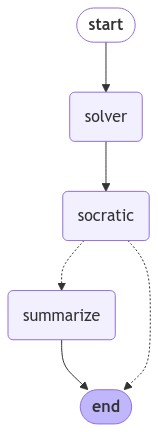

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(State)
workflow.add_node("solver", simple_solver)
workflow.add_node("socratic", socratic)
workflow.add_node("summarize", summarize_conversation)

workflow.add_edge(START, "solver")
workflow.add_edge("solver", "socratic")
workflow.add_conditional_edges("socratic", should_summarize, {"summarize": "summarize", END: END})
workflow.add_edge("summarize", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "5"}}

input_message = HumanMessage(content="what is hashing?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I think it is used in hash maps")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I think it has to do with mapping from one data set to another but I'm not sure how")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hashing is a fundamental concept in computer science, but let's break it down. 

Imagine you have a huge library with an enormous number of books. Each book has a unique title, author, and content. Now, imagine you want to find a specific book quickly. One way to do this is to create a catalog or an index that maps the book's title to a specific location on a shelf.

In a similar way, in computer science, we have large amounts of data that we need to store and retrieve efficiently. Can you think of how we might create a similar "catalog" or "index" for this data? What characteristics would this catalog need to have to be efficient?
================================== Ai Message ==================================

Hashing is indeed used in hash maps, also known as hash tables or dictionaries. 

A hash map is a data structure that stores key-value pairs, where each key is unique and maps to a specific value.

In [15]:
graph.get_state(config).values.get("summary","")

''

In [16]:
input_message = HumanMessage(content="what have we been talking about?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

We've been discussing hashing, specifically in the context of hash maps. We've been exploring what hashing is, its purpose, and how it's used to efficiently store and retrieve key-value pairs in hash maps.

You've been making great progress, thinking about how hashing works and how it might be used to map keys to indices in a hash map. We've been using a hypothetical example of storing a person's name as a key and their phone number as the value to help illustrate the concept.

Let's keep going! Where were we? Ah yes, we were discussing how to take a string key and generate a numerical value that we could use to determine the location in the array where the corresponding value should be stored. Do you want to take another stab at that?


/var/folders/mp/l7svtd7x14s0qp_j0_4v97gm0000gn/T/ipykernel_73610/1130683309.py:17: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


In [17]:
graph.get_state(config).values.get("summary","")

"**Conversation Summary: Hashing and Hash Maps**\n\nWe discussed the concept of hashing in computer science and its application in hash maps (also known as hash tables or dictionaries). Key points include:\n\n1. Hashing is a process of mapping one set of data to another, often to reduce complexity or size.\n2. Hashing is used in hash maps to store key-value pairs, where each key is unique and maps to a specific value.\n3. We explored how hashing could be used to take a key (like a string or object) and map it to a specific index in a hash map's underlying array.\n4. We brainstormed ways to generate a numerical value from a string key, which could be used to determine the location in the array where the corresponding value should be stored.\n\nThe conversation aimed to introduce the basics of hashing and its role in hash maps, encouraging critical thinking and exploration of the concept."

In [ ]:
for chunk in graph.stream({"messages": input_message}, config, stream_mode="updates"):
    chunk